# Build MNIST-1D

In [2]:
# Run this if you're in a Colab
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 148 (delta 49), reused 124 (delta 26), pack-reused 0
Receiving objects: 100% (148/148), 6.47 MiB | 32.34 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import time, copy
import torch
import torch.nn.functional as F
import random
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow as tf

from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.train import get_model_args, train_model
from mnist1d.models import ConvBase, GRUBase, MLPBase, LinearBase
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

# tqdm - package used to shoe a progress bar when loops executing
# tqdm - "progress" in arabic and obriviation for  "Te Quiero DeMaciado" 
# in Spanish (I love you so much)
from tqdm import tqdm 

from google.colab import drive
drive.mount('/content/gdrive')
project_dir = "/content/gdrive/My Drive/Research/metalearn_afunc/"

PROJECT_DIR = './'

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

Mounted at /content/gdrive


## Attaching GPU if any

In [4]:
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE) 

Using: cpu


## Download the MNIST-1D dataset

In [5]:
# args = mnist1d.get_dataset_args()
# args.num_samples = 10000
# data = mnist1d.get_dataset(args=args, download=False, regenerate=True)  # need to regenerate, since baseline dataset only has 4000/1000 samples
import sys ; sys.path.append('..')  # useful if you're running locally
import mnist1d

args = mnist1d.get_dataset_args()
data = mnist1d.get_dataset(args, path='./mnist1d_data.pkl', download=True) # This is the default setting

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))

print("Length of each input: {}".format(data['x'].shape[-1]))

print("Number of classes: {}".format(len(data['templates']['y'])))

train_data_size = len(data['x'])
test_data_size = len(data['x_test'])

print(train_data_size)
print(test_data_size)

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each input: 40
Number of classes: 10
4000
1000


In [6]:
print(list(data))

['x', 'x_test', 'y', 'y_test', 't', 'templates']


# TESTER

In [7]:
from numpy.random.mtrand import rand
  
# generate a random subset of indices for the training and test data
random_num_generator = np.random.RandomState(args.seed)

# Create a list of random seeds
seeds_list = np.random.randint(4000, size = 4)

seeds_list

array([  69, 2863, 1923, 2923])

## Initialize Variables

In [8]:
train_data_size = len(data['x'])
test_data_size = len(data['x_test'])

## Initialize the hyperparameters

In [9]:
t = 4000
m = int( 0.7 * train_data_size)

## Sample t random subsets of [n] of size m: I_1, I_2, I_3...

In [10]:
from numpy.random.mtrand import rand
import random
from datetime import datetime
# generate a random subset of indices for the training and test data
random_num_generator = np.random.RandomState(15)

# Generate subset of random indices of size m from (0,train_data_size) without replacement.
random_indices = np.random.choice(train_data_size, size = m, replace = False)

print(len(random_indices))

train_images = data["x"][random_indices]
print(np.shape(train_images))

2800
(2800, 40)


In [11]:

# seeds_list = np.random.randint(4000, size = 30)
# print(seeds_list)
# Random number with system time
random.seed(datetime.now())    

random.seed(50)
names = [1,2,3,4,5]

possible_choices = [item for item in range(0, train_data_size)]

ass = []

for i in range(3):

  random_item = random.choices(possible_choices, k = 7)
  # print(random_item)
  ass.append(random_item)

print(ass[0])
print(ass[1])
# random_item2 = random.choices(possible_choices, k = 7)
# print(random_item2)




# if random_indices.all() == random_indices2.all():
#   print("same")

print(data['x'][ass[0]])

[1990, 1064, 2549, 969, 1892, 3881, 340]
[1269, 2705, 340, 613, 3301, 3918, 1277]
[[-0.99427287 -0.77363915  0.67507555  2.35687271  3.28921536  3.4056122
   3.45610785  2.99516802  1.9821187  -0.01781248 -0.14772575  0.34728996
   0.66137919  0.52528568  0.30792429 -0.28700262 -0.57682296 -0.36166547
  -0.29893368 -0.79328791 -0.59188887 -0.2747718  -0.11713348  0.22533355
   0.56171294  0.75485758  0.39012666  0.04359686 -0.30041359 -0.05940603
   0.12126496 -0.2112411  -1.03835406 -1.27073896 -0.78499144 -0.45975012
   0.39118461  1.09213456  1.54987907  2.09784364]
 [ 1.1667885   0.97302668  1.01010537  3.40865062  3.42590873  2.33349808
   1.76195695  0.69002463 -0.1772354   0.33523674  0.78751824  1.66013649
   0.84393445  0.24483719  0.05967334 -0.32707223 -0.06433012  0.69237339
   1.00911506  1.30179038  1.44016474  1.48990034  0.86453703  0.31378936
  -0.30657656 -0.4583665  -0.40428209 -0.61547741 -0.57806753 -0.22113201
  -0.26679838 -0.16287182 -0.16175157 -0.6938462  -1.4

In [12]:
def create_subsets(dataset, t_iterations, m_ratio):
  '''Creates a subset of a dataset with given ratio. Parameter t_iterations - number of iterations / subsets. m_ratio - size of the subset.'''
  # Lists that will contain subsets of random samples
  # train_random_samples = []
  # test_random_samples = []

  random.seed(50)

  

  # Create a list of subsets
  list_of_subsets = []


  possible_choices = [item for item in range(0, train_data_size)]

  # create a random number generator
  # random_num_generator = np.random.RandomState(args.seed)

  # Create a list of random seeds
  # seeds_list = np.random.randint(t_iterations, size = t_iterations)
  # print(seeds_list)
  for i in range(t_iterations):
    # Create a subset structure with the same testing data
    subset = {'x':None,'y':None, 'x_test':dataset['x_test'],'y_test':dataset['y_test'],'indices':None}
    
    # create a random number generator
    # random_num_generator = np.random.RandomState(seeds_list[i])

    # Generate subset of random indices of size m from (0,train_data_size) without replacement.
    # random_indices = random_num_generator.choice(train_data_size, size = m, replace = False)
    random_indices = random.choices(possible_choices, k = m)
    # Save the random indices in the subset structure
    subset['indices'] = random_indices
    
    # Create a subset of training images and then of testing images / labels
    subset['x'] = dataset["x"][random_indices]
    subset['y'] = dataset["y"][random_indices]

    # Append the subset to the lists of subsets
    list_of_subsets.append(subset)

  return list_of_subsets


In [13]:
get_model_args(as_dict=True)

{'batch_size': 100,
 'checkpoint_every': 1000,
 'device': 'cpu',
 'eval_every': 250,
 'hidden_size': 256,
 'input_size': 40,
 'learning_rate': 0.01,
 'output_size': 10,
 'print_every': 1000,
 'seed': 42,
 'total_steps': 8000,
 'weight_decay': 0}

## Create all necessary subsets

In [14]:
subsets = create_subsets(data,t,m)

print(subsets[1]['indices'])
print(subsets[13]['indices'])

[2419, 625, 1385, 3072, 3309, 3386, 1930, 2027, 179, 1341, 3253, 1879, 3460, 3298, 2823, 3056, 3860, 764, 3344, 3818, 820, 2706, 1141, 894, 3883, 1726, 112, 1746, 3898, 2603, 2838, 2412, 3850, 39, 1579, 2726, 888, 1536, 3581, 1680, 622, 3277, 526, 1796, 163, 2602, 2215, 1743, 1590, 2403, 3635, 1081, 66, 3284, 1868, 463, 2642, 792, 1472, 3529, 2968, 418, 2685, 451, 2451, 1875, 1624, 1333, 1294, 777, 1808, 1059, 2640, 3459, 1221, 2315, 292, 816, 3373, 669, 2621, 3487, 1491, 547, 2438, 449, 2059, 3457, 2460, 1500, 3923, 3746, 2393, 1857, 461, 3186, 2638, 3859, 3965, 2836, 2133, 3467, 696, 2179, 3391, 2171, 2620, 3033, 2731, 561, 820, 2822, 3708, 1657, 70, 238, 3194, 245, 2015, 3121, 1157, 2613, 2463, 3066, 3807, 3297, 3208, 3656, 2443, 751, 340, 1725, 2911, 1771, 349, 1899, 3270, 643, 1431, 1333, 3750, 1979, 2905, 827, 1899, 2218, 3658, 2562, 2150, 2368, 3141, 2793, 858, 3943, 2306, 3393, 3343, 630, 138, 1938, 1941, 3034, 742, 38, 2462, 727, 3741, 1371, 276, 2474, 488, 914, 956, 3191, 398

## Algorithm A

In [15]:
# get the model info
args = get_model_args()

# list to keep all the models
list_of_mlp_models = []
list_of_ConvBase_models = []

# list ot keep all the training results
trained_mlp_model_results = []
trained_ConvBase_model_results = []

def train_MLPBase_models(t,subsets,args):
  '''Creates t MLPBase models. Parameter t - number of trials.'''
  # Create and traing t models
  for k in range(t):
    # set the seed
    set_seed(k)

    # create a model
    model = MLPBase(args.input_size, args.output_size)
    
    # append model to the list of models
    list_of_mlp_models.append(model)

    # define the subset of data you want to use
    data_subset = subsets[k]

    # train the model
    mlp_training_results = train_model(data_subset, model, args)

    # append the results of the model
    trained_mlp_model_results.append(mlp_training_results)

  return list_of_mlp_models, trained_mlp_model_results

def train_ConvBase_models(t,subsets,args):
  '''Creates t ConvBase models. Parameter t - number of trials.'''
  # Create and traing t models
  for k in range(t):
    # set the seed
    #set_seed(args.seed)
    set_seed(k)

    # create a model
    model = ConvBase(output_size=args.output_size)
    
    # append model to the list of models
    list_of_ConvBase_models.append(model)

    # define the subset of data you want to use
    data_subset = subsets[k]

    # train the model
    ConvBase_training_results = train_model(data_subset, model, args)

    # append the results of the model
    trained_ConvBase_model_results.append(ConvBase_training_results)

  return list_of_ConvBase_models, trained_ConvBase_model_results



## Train the models on the subsets

In [16]:
# MLP base
list_of_mlp_models, trained_mlp_model_results = train_MLPBase_models(3,subsets,args)

# ConvBase
list_of_ConvBase_models, trained_ConvBase_model_results = train_ConvBase_models(3,subsets,args)

Initialized MLPBase model with 15210 parameters
step 1000, dt 1.30s, train_loss 1.610e-01, test_loss 3.271e+00, train_acc 99.2, test_acc 54.1
step 2000, dt 1.22s, train_loss 2.064e-04, test_loss 4.099e+00, train_acc 100.0, test_acc 54.6
step 3000, dt 1.27s, train_loss 7.325e-05, test_loss 4.202e+00, train_acc 100.0, test_acc 53.8
step 4000, dt 1.25s, train_loss 4.667e-05, test_loss 4.295e+00, train_acc 100.0, test_acc 54.0
step 5000, dt 1.25s, train_loss 3.233e-05, test_loss 4.390e+00, train_acc 100.0, test_acc 53.9
step 6000, dt 1.24s, train_loss 1.811e-05, test_loss 4.486e+00, train_acc 100.0, test_acc 54.1
step 7000, dt 1.25s, train_loss 7.438e-06, test_loss 4.587e+00, train_acc 100.0, test_acc 54.3
step 8000, dt 1.23s, train_loss 8.724e-06, test_loss 4.694e+00, train_acc 100.0, test_acc 54.3
Initialized MLPBase model with 15210 parameters
step 1000, dt 1.12s, train_loss 1.235e-02, test_loss 3.211e+00, train_acc 99.8, test_acc 52.8
step 2000, dt 1.17s, train_loss 3.911e-04, test_los

In [17]:
for sub_index, subset in enumerate(subsets):
    if 123 in subset['indices']:
      print("x is in subset with index: ", sub_index)
      # trainset_mask[subset_index]  = True

x is in subset with index:  0
x is in subset with index:  4
x is in subset with index:  6
x is in subset with index:  7
x is in subset with index:  9
x is in subset with index:  16
x is in subset with index:  17
x is in subset with index:  19
x is in subset with index:  22
x is in subset with index:  23
x is in subset with index:  26
x is in subset with index:  28
x is in subset with index:  29
x is in subset with index:  30
x is in subset with index:  31
x is in subset with index:  32
x is in subset with index:  33
x is in subset with index:  35
x is in subset with index:  38
x is in subset with index:  44
x is in subset with index:  46
x is in subset with index:  47
x is in subset with index:  49
x is in subset with index:  50
x is in subset with index:  51
x is in subset with index:  54
x is in subset with index:  57
x is in subset with index:  60
x is in subset with index:  63
x is in subset with index:  64
x is in subset with index:  66
x is in subset with index:  68
x is in subse

In [20]:
np.shape(data['x'])[0]

4000

# Memorization

In [23]:

from mnist1d import train

def estimate_mem_infl(list_of_models, model_results, subset_index, subsets, x_i_index, x_train, y_train):
  '''Computes memorization and influence estimates for a single x_i from the 
  dataset. 
  Parameters: list of all models and their results as well as the subset index 
  in the list of the subsets, the list of subsets, and the index of an x in 
  the training set for which we are looking to find memorization for.'''

  # list of all subset indices where the x_i is present
  # trainset_mask = np.zeros(train_data_size, dtype=np.bool)
  x_in_subsets= []
  x_not_in_subsets = []

  # Check in which subsets is the x_i present
  for sub_index, subset in enumerate(subsets):
    if x_i_index in subset['indices']:
      # Append the index to the list of indices for the chosen subsets 
      x_in_subsets.append(sub_index)

      # print("x is in subset with index: ", sub_index)
      # trainset_mask[subset_index]  = True
    else:
      # Append the index of a subset where x is not present
      x_not_in_subsets.append(sub_index)

  x_in_picked_models = []
  x_not_in_picked_models = []

  # Take the models that are trained based on those subsets where x is present
  for index in x_in_subsets:
    x_in_picked_models.append(list_of_models[index])

  # Take the models that are trained based on those subsets where x_i is NOT present
  for index in x_not_in_subsets:
    x_not_in_picked_models.append(list_of_models[index])

  # picked_models = [model for index,model in enumerate(list_of_models) if index] 

  # Get the image and its label
  input_image = x_train[x_i_index]
  image_label = y_train[x_i_index]

  # Count correct predictions
  num_correct_pred = 0

  # Check how many of these models are not making the error in classification
  for model in x_in_picked_models:
    
    prediction = model(input_image).argmax(-1).cpu().numpy()
    target = image_label.cpu().numpy().astype(np.float32)

    # Check if the predicion is the same as the label
    # If so, increment the count of correct rpedictions
    if prediction == target:
      num_correct_pred += 1
  
  # Take the fraction of the number of models that are predicting correctly
  # over the total number of models.
  # The result is the first probability in the equation .

  p_x_i_in = num_correct_pred / np.shape(x_train)[0]




  # Count correct predictions
  num_correct_pred = 0

  # Check how many of these models are not making the error in classification
  for model in x_not_in_picked_models:
    
    prediction = model(input_image).argmax(-1).cpu().numpy()
    target = image_label.cpu().numpy().astype(np.float32)

    # Check if the predicion is the same as the label
    # If so, increment the count of correct rpedictions
    if prediction == target:
      num_correct_pred += 1
  
  # Take the fraction of the number of models that are predicting correctly
  # over the total number of models.
  # The result is the first probability in the equation .

  p_x_i_not_in = num_correct_pred / np.shape(x_train)[0]


  


  # # Create an inverse of the mask... Subsets where x_i is not present
  # # An inverse of the mask (instances that are not used in this subset)
  # # inv_mask = np.logical_not(trainset_mask)

  # # Take the models that are trained on the subsets where x_i is not present
  # selected_models = []
  # # Check in which subsets is the x_i present
  # for sub_index, subset in enumerate(subsets):
  #   if x_i_index in subset['indices']:
  #     # Append the index to the list of indices for the chosen subsets 
  #     selected_models.append(sub_index)

  #     # print("x is in subset with index: ", sub_index)
  #     # trainset_mask[subset_index]  = True

  # picked_models = []
  # # Take the models of that are trained based on those subsets
  # for index in selected_models:
  #   picked_models.append(list_of_models[index])

  # # check how many of them are NOT making the error in classification

  # # Take the fraction of the number of models that are predicting correctly
  # # over the total number of models.
  
  # # The result is the second probability in the equation 


  #  Memorization for x_i  is the first probability minus second probability

  memorization_estimate_x_i = p_x_i_in - p_x_i_not_in

  return memorization_estimate_x_i



  # # Create a list of masks that will mark what instances are used in each subset
  # trainset_mask = np.zeros(train_data_size, dtype=np.bool)
  # trainset_mask[subsets[subset_index]['indices']]  = True

  # # An inverse of the mask (instances that are not used in this subset)
  # inv_mask = np.logical_not(trainset_mask)

  # # Convert splits into the proper forms
  # x_train, x_test = torch.Tensor(subsets[subset_index]['x']), torch.Tensor(subsets[subset_index]['x_test'])
  # y_train, y_test = torch.LongTensor(subsets[subset_index]['y']), torch.LongTensor(subsets[subset_index]['y_test'])

  # # Accuracy of the training set
  # # trainset_correctness = train.accuracy(list_of_models[subset_index], subsets[subset_index]['x'],subsets[subset_index]['y'])
  # trainset_correctness = train.accuracy(list_of_models[subset_index], x_train,y_train)

  # # Accuracy of the testing set
  # # testset_correctness = train.accuracy(list_of_models[subset_index], subsets[subset_index]['x_test'],subsets[subset_index]['y_test'])
  # testset_correctness = train.accuracy(list_of_models[subset_index], x_test,y_test)

  # # memorization estimate
  # def memorization_estimate(x, mask, axis=0, esp=1e-10):
  #   return (np.sum(x * mask, axis=axis) / np.maximum(np.sum(mask, axis=axis), esp)).astype(np.float32)

  # #influence estimate
  # # def influence_estimate(x, mask, esp=1e-10):
  # #   x = x.T.astype(np.float32)
  # #   return (np.matmul(x, mask) / np.maximum(np.sum(mask, axis=0, keepdims=True), esp)).astype(np.float32)

  # mem_est = memorization_estimate(trainset_correctness, trainset_mask) - memorization_estimate(trainset_correctness, inv_mask)
  # # infl_est = influence_estimate(testset_correctness, trainset_mask) - influence_estimate(testset_correctness, inv_mask)

  # # return dict(memorization=mem_est, influence=infl_est)
  # return dict(memorization=mem_est)

estimates = []
x_i = 0

for subset in tqdm(range(15)):
  print()
  print(subset)
  
  estimates.append(estimate_mem_infl(list_of_mlp_models, trained_mlp_model_results, subset,subsets,x_i,data['x'],data['y'] ))

  x_i += 1

# estimates = estimate_mem_infl(list_of_mlp_models, trained_mlp_model_results, 1,subsets )


  0%|          | 0/15 [00:00<?, ?it/s]


0


  0%|          | 0/15 [00:00<?, ?it/s]


IndexError: ignored

In [ ]:
estimates

[{'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0},
 {'memorization': 0.0}]

# Histogram of Memorization 

[1]


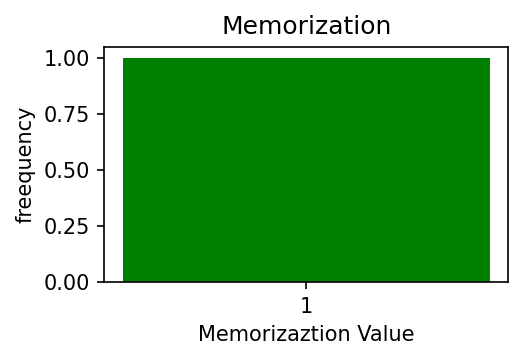

In [ ]:
fig = plt.figure(figsize=(3.5, 2.5), dpi=150)
# err_ixs = np.where(guesses!=trues)
# err_classes = trues[err_ixs]

# Count occurrence of element '3' in numpy array
frequencies = {}
for element in estimates:
  if element not in list(frequencies.keys()):
    frequencies[str(element)] = 1
  else:
    frequencies[str(element)] += 1
    
# x = list(frequencies.keys())
y = list(frequencies.values())
x_ = [i for i, _ in enumerate(frequencies)]

print(y)

values = [frequencies[i] for i in (frequencies)]

plt.bar(x, y, color='green')
plt.xlabel("Memorizaztion Value")
plt.ylabel("freequency")
plt.title("Memorization")

plt.xticks(x, y)

plt.tight_layout() ; plt.show()

# Showing Examples

In [ ]:
def show_examples(estimates, n_show=10):
  def show_image(ax, image, vmin=None, vmax=None, title=None):
    if image.ndim == 3 and image.shape[2] == 1:
      image = image.reshape((image.shape[0], image.shape[1]))
    ax.axis('off')
    ax.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    if title is not None:
      ax.set_title(title, fontsize='x-small')

  n_show = 10
  n_context1 = 4
  n_context2 = 5

  fig, axs = plt.subplots(nrows=n_show, ncols=n_context1+n_context2+1,
                          figsize=(n_context1+n_context2+1, n_show))
  idx_sorted = np.argsort(np.max(estimates['influence'], axis=1))[::-1]
  for i in range(n_show):
    # show test example
    idx_tt = idx_sorted[i]
    label_tt = data['test_int_labels'][idx_tt]
    show_image(axs[i, 0], data['test_byte_images'][idx_tt], 
               title=f'test,L={label_tt}')

    def _show_contexts(idx_list, ax_offset):
      for j, idx_tr in enumerate(idx_list):
        label_tr = data['train_int_labels'][idx_tr]
        infl = estimates['influence'][idx_tt, idx_tr]
        show_image(axs[i, j+ax_offset], data['train_byte_images'][idx_tr],
                   title=f'tr,L={label_tr},infl={infl:.3f}')

    # show training examples with highest influence
    idx_sorted_tr = np.argsort(estimates['influence'][idx_tt])[::-1]
    _show_contexts(idx_sorted_tr[:n_context1], 1)

    # show random training examples from the same class
    idx_class = np.nonzero(data['train_int_labels'] == label_tt)[0]
    idx_random = np.random.choice(idx_class, size=n_context2, replace=False)
    _show_contexts(idx_random, n_context1 + 1)

  plt.tight_layout()
  plt.savefig('mnist-examples.pdf', bbox_inches='tight')